# Extracting data, downloading and reading the .pdf file

In [2]:
import os
import requests
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import re
from pypdf import PdfReader
import pdfplumber
from datetime import datetime
%matplotlib inline

base_url = 'https://www.fenabrave.org.br/portal/files/'

# creating variables and url
previous_month = (datetime.now().month - 1) % 12
formatted_month = f'{previous_month:02d}'

pdfpath = r'C:/Users/vinig/OneDrive/Documentos/PdfDataExtraction/pdf/'
filename = f'2024_{formatted_month}_02.pdf'

download_url = base_url + filename
filepath = os.path.join(pdfpath, filename)

# downloading the most updated file (last month).pdf
try:
    response = requests.get(download_url)
    response.raise_for_status()
    
    with open(filepath, 'wb') as file:
        file.write(response.content)
    print(f'downloaded: {filename}')

except requests.exceptions.HTTPError as http_err:
    print(f'http error occurred: {http_err}')

# to use in date columns
file_date = os.path.splitext(os.path.basename(filepath))[0]
file_date = file_date.replace('_', '-')  # date format will be: 'YYYY-MM-DD'

text_list = []
# open the pdf and extracting text from each page
with pdfplumber.open(filepath) as pdf:
    for i in range(10, 16):
        page = pdf.pages[i]
        text = page.extract_text()
        text_list.append(text)

combined_text = "\n".join(text_list)
print (combined_text)

# function to fix special chars(cid:xx) 
def cidToChar(cidx):
    return chr(int(re.findall(r'\(cid\:(\d+)\)',cidx)[0]) + 29)
def replace_cid(text):
    text = re.sub(r'\(cid\:\d+\)', lambda m: cidToChar(m.group(0)), text)
    text = text.replace('»', 'º')
    text = re.sub(r' É|É ', '', text)  
    return text

processed_text = replace_cid(combined_text)

downloaded: 2024_07_02.pdf
Ed. 259
Informativo - Emplacamentos
São Paulo, Agosto de 2024
Modelos mais emplacados acumulado até Jul/2024
AUTOMÓVEIS
Veículos de Entrada
2024 2024 2024
Modelo Part.
Jun Jul Acumulado
1º FIAT/MOBI 6.007 6.807 39.041 57,20%
2º RENAULT/KWID 4.520 3.520 29.155 42,72%
3º VW/GOL 2 3 33 0,05%
4º FIAT/UNO 0 3 10 0,01%
5º VW/UP 0 1 4 0,01%
6º GM/CHEVETTE 1 0 3 0,00%
7º FIAT/PALIO 0 0 = 2 0,00%
8º FORD/KA 1 0 1 0,00%
9º GM/CELTA 0 0 = 1 0,00%
Total 10.531 10.334 68.251 100%
Hatch Pequenos
2024 2024 2024
Modelo Part.
Jun Jul Acumulado
1º VW/POLO 9.683 12.543 70.405 23,76%
2º GM/ONIX 8.852 7.423 51.026 17,22%
3º HYUNDAI/HB20 9.760 7.228 49.924 16,85%
4º FIAT/ARGO 7.422 8.663 48.284 16,30%
5º TOYOTA/YARIS HB 2.336 2.819 15.132 5,11%
6º CITROEN/C3 1.985 2.111 12.242 4,13%
7º PEUGEOT/208 2.367 2.371 12.241 4,13%
8º BYD/DOLPHIN 1.513 1.467 11.074 3,74%
9º BYD/DOLPHIN MINI 1.318 1.488 10.536 3,56%
10º HONDA/CITY HATCH 1.232 1.590 7.264 2,45%
11º GWM/ORA 03 589 398 4.085 1,

In [3]:
# use regex to find all occurrences between '1ª and Total' 
matches = re.findall(r'1º.*?Total', processed_text, re.DOTALL)

appended_text = "\n".join(matches)
entries = appended_text.split('\n')

df = pd.DataFrame(entries)

# remove 'Total' rows
drop_patterns = ['Total','=']
drop_regex = '|'.join(drop_patterns)

df = df[~df[0].str.contains(drop_regex, na=False)]

print(df)

                                              0
0        1º FIAT/MOBI 6.007 6.807 39.041 57,20%
1     2º RENAULT/KWID 4.520 3.520 29.155 42,72%
2                        3º VW/GOL 2 3 33 0,05%
3                      4º FIAT/UNO 0 3 10 0,01%
4                          5º VW/UP 0 1 4 0,01%
..                                          ...
141     36º PORSCHE/CAYENNE 324 175 1.014 0,21%
142        37º GM/TRAILBLAZER 133 173 987 0,20%
143  38º LAND ROVER/DISCOVERY 130 150 983 0,20%
144                39º BMW/X3 184 151 878 0,18%
145                40º AUDI/Q5 119 89 840 0,17%

[117 rows x 1 columns]


## Feature Engineering

In [5]:
# splitting the original dataframe in 2 to make data cleaning easier
def last_4_values(text):
    parts = text.split(' ')
    return parts[-4:]

def remove_last_4_values(text):
    parts = text.split(' ')
    return ' '.join(parts[:-4]) 

df[['last_month', 'emplacados', 'acumulado_anual', 'market_share']] = df.iloc[:,0].apply(lambda x: pd.Series(last_4_values(x)))

df.iloc[:,0] = df.iloc[:,0].apply(remove_last_4_values)

df.columns = ['marca_carro', 'last_month', 'emplacados', 'acumulado_anual', 'market_share']
values_df = df[['last_month', 'emplacados', 'acumulado_anual', 'market_share']].copy()

df = df.drop(columns=['last_month', 'emplacados', 'acumulado_anual', 'market_share'])

# Optional: Display the DataFrames to verify
print('df:')
print(df)
print('\nvalues_df:')
print(values_df)

df:
                  marca_carro
0                1º FIAT/MOBI
1             2º RENAULT/KWID
2                   3º VW/GOL
3                 4º FIAT/UNO
4                    5º VW/UP
..                        ...
141       36º PORSCHE/CAYENNE
142        37º GM/TRAILBLAZER
143  38º LAND ROVER/DISCOVERY
144                39º BMW/X3
145               40º AUDI/Q5

[117 rows x 1 columns]

values_df:
    last_month emplacados acumulado_anual market_share
0        6.007      6.807          39.041       57,20%
1        4.520      3.520          29.155       42,72%
2            2          3              33        0,05%
3            0          3              10        0,01%
4            0          1               4        0,01%
..         ...        ...             ...          ...
141        324        175           1.014        0,21%
142        133        173             987        0,20%
143        130        150             983        0,20%
144        184        151             878        0

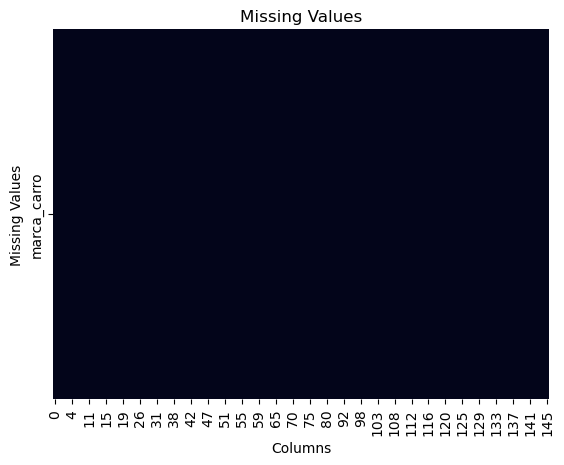

       marca_carro
0     1º FIAT/MOBI
1  2º RENAULT/KWID
2        3º VW/GOL
3      4º FIAT/UNO
4         5º VW/UP


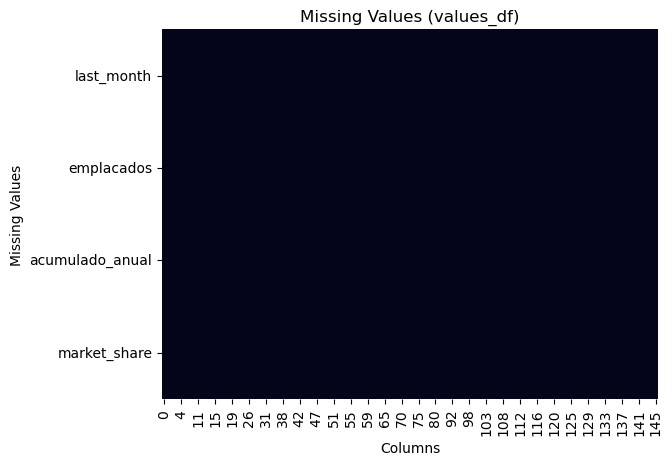

  last_month emplacados acumulado_anual market_share
0      6.007      6.807          39.041       57,20%
1      4.520      3.520          29.155       42,72%
2          2          3              33        0,05%
3          0          3              10        0,01%
4          0          1               4        0,01%


In [6]:
# using heatmap to see if dataframe disribution and, missing values

ax = plt.axes()
sns.heatmap(df.isna().transpose(), cbar=False, ax=ax)
plt.title('Missing Values', fontsize=12)
plt.xlabel('Columns', fontsize = 10) 
plt.ylabel('Missing Values', fontsize = 10)
plt.show()

print(df.head())

# using heatmap to see if dataframe disribution and, missing values

ax = plt.axes()
sns.heatmap(values_df.isna().transpose(), cbar=False, ax=ax)
plt.title('Missing Values (values_df)', fontsize=12)
plt.xlabel('Columns', fontsize = 10) 
plt.ylabel('Missing Values', fontsize = 10)
plt.show()

print(values_df.head())

In [7]:
# cleaning the df, dropping the position value and splitting the [brand/car name0 name1] in [brand] and [car_name0_name1]
df['marca_carro'] = df['marca_carro'].str.replace(r'\d+º', '', regex=True)

df = df.map(lambda x: x.strip() if isinstance(x, str) else x)

df['marca_carro'] = df['marca_carro'].str.replace(' ', '_')

df[['marca', 'modelo']] = df['marca_carro'].str.split('/', expand=True)

df = df.drop(columns=['marca_carro'])

print(df)

          marca       modelo
0          FIAT         MOBI
1       RENAULT         KWID
2            VW          GOL
3          FIAT          UNO
4            VW           UP
..          ...          ...
141     PORSCHE      CAYENNE
142          GM  TRAILBLAZER
143  LAND_ROVER    DISCOVERY
144         BMW           X3
145        AUDI           Q5

[117 rows x 2 columns]


In [8]:
# cleaning values_df dataframe, removing dots and dropping last_month and market_share columns (will be created later in DataViz)
values_df = values_df.map(lambda x: x.replace('.', '') if isinstance(x, str) else x)

values_df = values_df.drop(columns=['last_month', 'market_share'])

print(values_df)

    emplacados acumulado_anual
0         6807           39041
1         3520           29155
2            3              33
3            3              10
4            1               4
..         ...             ...
141        175            1014
142        173             987
143        150             983
144        151             878
145         89             840

[117 rows x 2 columns]


In [9]:
# concatenate the two cleaned and transformed dataframes (df and values_df)
df_final = pd.concat([df, values_df], axis=1)

# using file_date created in the 1st cell
df_final['data'] = file_date

print(df_final)

          marca       modelo emplacados acumulado_anual        data
0          FIAT         MOBI       6807           39041  2024-07-02
1       RENAULT         KWID       3520           29155  2024-07-02
2            VW          GOL          3              33  2024-07-02
3          FIAT          UNO          3              10  2024-07-02
4            VW           UP          1               4  2024-07-02
..          ...          ...        ...             ...         ...
141     PORSCHE      CAYENNE        175            1014  2024-07-02
142          GM  TRAILBLAZER        173             987  2024-07-02
143  LAND_ROVER    DISCOVERY        150             983  2024-07-02
144         BMW           X3        151             878  2024-07-02
145        AUDI           Q5         89             840  2024-07-02

[117 rows x 5 columns]


In [10]:
# see whole DF
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

print(df_final)

pd.reset_option('display.max_rows')
pd.reset_option('display.max_columns')

num_rows, num_col = df_final.shape

print(f'Rows: {num_rows}')
print(f'Columns: {num_col}')

          marca         modelo emplacados acumulado_anual        data
0          FIAT           MOBI       6807           39041  2024-07-02
1       RENAULT           KWID       3520           29155  2024-07-02
2            VW            GOL          3              33  2024-07-02
3          FIAT            UNO          3              10  2024-07-02
4            VW             UP          1               4  2024-07-02
5            GM       CHEVETTE          0               3  2024-07-02
7          FORD             KA          0               1  2024-07-02
10           VW           POLO      12543           70405  2024-07-02
11           GM           ONIX       7423           51026  2024-07-02
12      HYUNDAI           HB20       7228           49924  2024-07-02
13         FIAT           ARGO       8663           48284  2024-07-02
14       TOYOTA       YARIS_HB       2819           15132  2024-07-02
15      CITROEN             C3       2111           12242  2024-07-02
16      PEUGEOT     

In [11]:
filename_tosave = os.path.splitext(filename)[0]

#.csv Save
csv_filepath =fr'C:/Users/vinig/OneDrive/Documentos/PdfDataExtraction/data/data{filename_tosave}.csv'

df_final.to_csv(csv_filepath, index=False, encoding='ISO-8859-1')

print(f'data.csv saved to {csv_filepath}')

data.csv saved to C:/Users/vinig/OneDrive/Documentos/PdfDataExtraction/data/data2024_07_02.csv


## LOAD data into AWS RDS and query the table to verify if the data is properly loaded

In [13]:
import sys
import os

csv_path = fr'C:/Users/vinig/OneDrive/Documentos/PdfDataExtraction/data/data{filename_tosave}.csv'

# Example usage for testing directly
user = ''
password = ''
host = 'rds.amazonaws.com'
port = '5432'  # Default port for PostgreSQL
database = ''
table_name = 'processed_test'

# Add the path of the 'scripts' directory to the Python path
sys.path.append(os.path.abspath(os.path.join('..', 'scripts')))

# Import the load_data_to_rds function from the loaddata.py script
from loaddata import load_data_to_rds

# Call the function to load data into RDS
load_data_to_rds(csv_path, user, password, host, port, database, table_name)


Data loaded from C:/Users/vinig/OneDrive/Documentos/PdfDataExtraction/data/data2024_07_02.csv
Connected to the database!
Data loaded into table 'processed_test'
Data from the table:
          marca       modelo  emplacados  acumulado_anual        data
0          FIAT         MOBI        6807            39041  2024-01-02
1       RENAULT         KWID        3520            29155  2024-01-02
2            VW          GOL           3               33  2024-01-02
3          FIAT          UNO           3               10  2024-01-02
4            VW           UP           1                4  2024-01-02
..          ...          ...         ...              ...         ...
666     PORSCHE      CAYENNE         175             1014  2024-07-02
667          GM  TRAILBLAZER         173              987  2024-07-02
668  LAND_ROVER    DISCOVERY         150              983  2024-07-02
669         BMW           X3         151              878  2024-07-02
670        AUDI           Q5          89        